In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
os.chdir("/home/jovyan/work/Face_Mask_Detection")
!pwd

/home/jovyan/work/Face_Mask_Detection


In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, optimizers, losses, initializers
from tensorflow.keras.utils import plot_model
from IPython.display import Image
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
import pandas as pd
import cv2
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import utils
from tensorflow.keras.applications import MobileNetV2

In [3]:
physical_gpus = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_gpus[0], True)

# Start

In [7]:
labels = ("without_mask", "with_mask")
train_dir = "dataset/train"
val_dir = "dataset/valid"
test_dir = "dataset/test"

ImageDataGenerator詳細：https://zhuanlan.zhihu.com/p/30197320

In [8]:
train_datagen = ImageDataGenerator(rescale=1/255)
val_datagen = ImageDataGenerator(rescale=1/255)

train_generator = train_datagen.flow_from_directory(train_dir, batch_size=100, class_mode="binary", target_size=(96, 96))
validation_generator = val_datagen.flow_from_directory(val_dir, batch_size=20, class_mode="binary", target_size=(96, 96))

train_num = 3161

Found 3161 images belonging to 2 classes.
Found 394 images belonging to 2 classes.


MobileNetV2 function：https://keras.io/api/applications/mobilenet/#mobilenetv2-function

layers len = 154


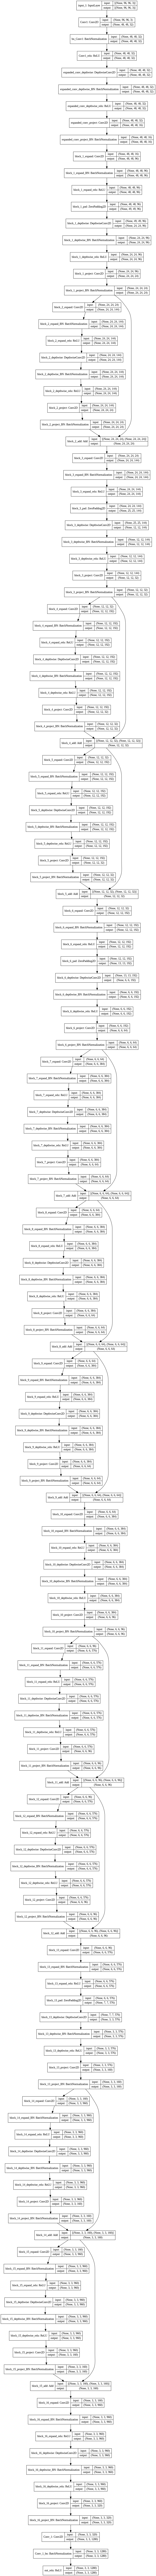

In [14]:
base_model = MobileNetV2(weights="imagenet", input_shape=(96, 96, 3), include_top=False)
print(f"layers len = {len(base_model.layers)}")
for layer in base_model.layers:
    layer.trainable = False
plot_model(base_model, show_shapes=True)

如何去掉模型的全連接層：https://blog.csdn.net/qq_29462849/article/details/83010854

In [16]:
model = keras.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(1000, activation="relu", kernel_initializer="he_normal"),
    layers.Dense(1000, activation="relu", kernel_initializer="he_normal"),
    layers.Dense(1, activation="sigmoid")
])
model.summary()
model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics="binary_accuracy"
)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_96 (Functio (None, 3, 3, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1000)              1281000   
_________________________________________________________________
dense_3 (Dense)              (None, 1000)              1001000   
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 1001      
Total params: 4,540,985
Trainable params: 2,283,001
Non-trainable params: 2,257,984
_________________________________________________________________


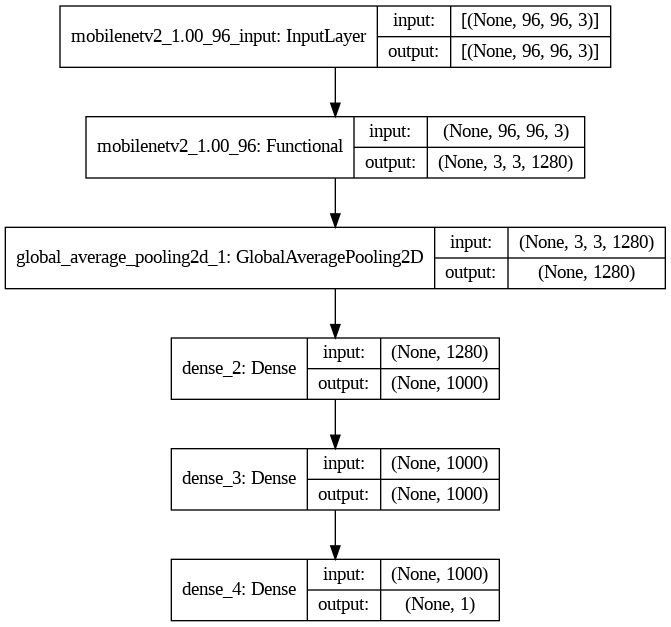

In [17]:
plot_model(model, show_shapes=True)

ReduceLROnPlateau待測試：https://hackmd.io/@allen108108/SyCsOIkxB

In [18]:
model_tag = 'mobilenetv2_3'
models_dir = 'models'
model_dir = os.path.join(models_dir, model_tag)
callbacks = []
''' EarlyStopping '''
callbacks.append(
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=100, verbose=1, mode="auto")
)
''' ModelCheckpoint '''
model_name = 'model.h5'
filepath = os.path.join(model_dir, model_name)
callbacks.append(
    keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=False, mode='auto', save_freq='epoch')
)
''' ModelCheckpoint '''
model_name = 'epoch_{epoch:05d}-val_loss_{val_loss:.3f}.h5'
filepath = os.path.join(model_dir, "checkpoint", model_name)
callbacks.append(
    keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=False, save_weights_only=False, mode='auto', save_freq='epoch')
)
''' TensorBoard '''
log_dir = os.path.join(models_dir, 'logs', model_tag)
callbacks.append(
  keras.callbacks.TensorBoard(log_dir=log_dir)
)
''' trainParam '''
batch_size = 1000
epochs = 10000
steps_per_epoch = int(train_num / batch_size)
print(f'steps_per_epoch = {steps_per_epoch}')
print(f'filepath = {filepath}')

steps_per_epoch = 3
filepath = models/mobilenetv2_3/checkpoint/epoch_{epoch:05d}-val_loss_{val_loss:.3f}.h5


# Train

In [19]:
trainHistory = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data=validation_generator,
    callbacks=callbacks
)

Epoch 1/10000
3/3 [==============================] - 211s 70s/step - loss: 1.8254 - binary_accuracy: 0.7417 - val_loss: 0.9454 - val_binary_accuracy: 0.8198
Epoch 2/10000
3/3 [==============================] - 1s 230ms/step - loss: 0.8219 - binary_accuracy: 0.7200 - val_loss: 0.3974 - val_binary_accuracy: 0.8401
Epoch 3/10000
3/3 [==============================] - 1s 251ms/step - loss: 0.3570 - binary_accuracy: 0.8563 - val_loss: 0.4951 - val_binary_accuracy: 0.8325
Epoch 4/10000
3/3 [==============================] - 1s 252ms/step - loss: 0.4166 - binary_accuracy: 0.8404 - val_loss: 0.3319 - val_binary_accuracy: 0.8452
Epoch 5/10000
3/3 [==============================] - 1s 234ms/step - loss: 0.3316 - binary_accuracy: 0.8754 - val_loss: 0.3179 - val_binary_accuracy: 0.8832
Epoch 6/10000
3/3 [==============================] - 1s 245ms/step - loss: 0.3215 - binary_accuracy: 0.8479 - val_loss: 0.3020 - val_binary_accuracy: 0.8579
Epoch 7/10000
3/3 [==============================] - 1s 23

# Result

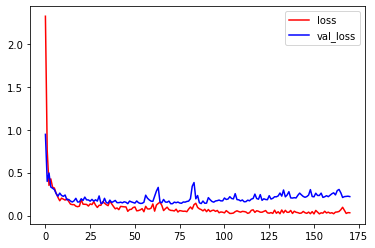

In [20]:
plt.plot(trainHistory.history['loss'], color='r', label='loss')
plt.plot(trainHistory.history['val_loss'], color='b', label='val_loss')
plt.legend()
plt.show()

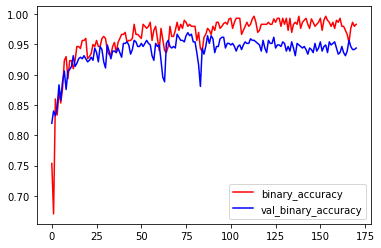

In [21]:
plt.plot(trainHistory.history['binary_accuracy'], color='r', label='binary_accuracy')
plt.plot(trainHistory.history['val_binary_accuracy'], color='b', label='val_binary_accuracy')
plt.legend()
plt.show()

# Test

In [22]:
best_model = load_model(f"models/{model_tag}/model.h5")

In [23]:
test_datagen = ImageDataGenerator(rescale=1/255)
test_generator = test_datagen.flow_from_directory(test_dir, shuffle=False, batch_size=406, class_mode="binary", target_size=(96, 96))
Y_test_classes = test_generator[0][1]

Found 394 images belonging to 2 classes.


In [24]:
loss, acc = best_model.evaluate(test_generator)
print(f"ACC = {acc * 100:.4f} %")

1/1 [==============================] - 1s 1s/step - loss: 0.1854 - binary_accuracy: 0.9162
ACC = 91.6244 %


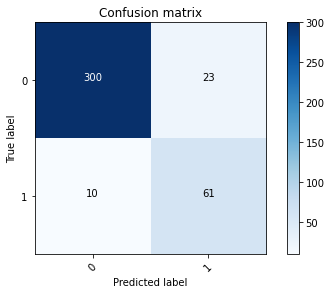

In [25]:
predicts = best_model.predict(test_generator)
predicts_classes = predicts >= 0.5
utils.plot_confusion_matrix(Y_test_classes, predicts_classes, 2)